Author: Sean Tulin
<br>
Date: Feb. 11, 2022
<br>
PHYS 2030 W22

# <font color=#46769B>Lesson 7: Markov Chain Monte Carlo for continuous distributions</font>

## <font color=#46769B>Motivation</font>

Let us generalize our discussion from Lesson 6 to the case of probability distribution functions of continuous variables. 



## <font color=#46769B>Metropolis algorithm for continuous distributions</font>

Suppose we have a target PDF $P(x)$, where $x$ is a continuous variable that we want to sample. To be concrete, let's consider an exponential function
$$P(x) = \left\{ \begin{array}{cc} a e^{-ax} & x > 0 \\ 0 & {\rm otherwise} \end{array} \right. \, .$$ 
For future reference, we recall that the true mean and standard deviation of this distribution are $\mu = \sigma = 1/a$.

The general procedure for performing an MCMC simulation is generally the same as for a discrete variable. 

### <font color=#46769B>Choosing your proposal distribution</font>

We need to decide on a proposal (transition) PDF $Q(x|x^\prime)$. In the Metropolis algorithm, the proposal distribution is assumed to be symmetric, i.e.,
$$Q(x|x^\prime) = Q(x^\prime|x) \, .$$
In this course, we will always choose a __normal distribution__ for our proposal distribution: 
$$Q(x|x^\prime) = \frac{1}{\sqrt{2\pi \sigma_q^2}} \, e^{-\frac{(x-x^\prime)^2}{2 \sigma_q^2}} \, .$$
That is, you draw the *new* sample $x$ from a normal distribution centered at the *old* sample $x^\prime$. 
This choice for $Q(x|x^\prime)$ is the most common one for MCMC simulations, in part because it is clearly symmetric (it is invariant under $x \leftrightarrow x^\prime$).

We still have a choice to make: we are free to choose any value for the width of our proposal distribution, $\sigma_q$. (We label it $\sigma_q$ to make it clear that it is related to the proposal PDF $Q$ and not to be confused with the true $\sigma$ from our target PDF $P$.)

There is always a "sweet spot" where $\sigma_q$ is neither too large nor too small, where your simulation will be optimized.
We will gain some experience in how to optimize $\sigma_q$ below.

Let's summarize the main idea of how to choose the best $\sigma_q$. The main goal of our MCMC simulation is to obtain a list of $x$ samples
$$(x_0, \, x_1, \, x_2, \, ... , \, x_{N-1})$$
that are scattered diversely throughout the region of maximum probability. Consider the figure below. The darker shaded region represents the region of higher probability and the green point represents $x^\prime$. (For visual clarity, the picture represents sampling two variables in a plane, say, $x$ and $y$.)

<div>
<img src="https://github.com/PHYS-2030-Computational-Methods/Lecture-notes/raw/main/figures/MCMC_step_size.png" width="600">
</div>

- If $\sigma_q$ is large, we are more likely to make larger steps in $x$. After a large step, $x$ will be far outside the most probable region. Such new points are unlikely to be accepted, and we end up with the same point $x^\prime$ repeated in our chain.

- If $\sigma_q$ is small, we are more likely to make smaller steps in $x$. Since each new step $x$ is near the old point $x^\prime$, the acceptance ratio is close to one and new points are likely to be accepted. However, we end up with many points that are closely correlated with each other.

- If $\sigma_q$ is just right, the step size will be comparable to the size of the region we want to sample from. We will have a mix of accepted and rejected samples.

In practice, it is important to __tune__ your MCMC to determine the best value of $\sigma_q$. This is similar to the iterative tuning we did for importance sampling.

### <font color=#46769B>Choosing your initial point</font>

The starting point in your chain $x_0$ is a value that we choose by hand, not a value we sample. The rule of thumb is: *Choose a value of $x_0$ that you wouldn't mind sampling later on in your chain*.

The figure here illustrates the main idea. A good starting point $x_0$ is in the region where the probability is high. A bad starting point is far outside this region, requiring many iterations just to get to the most probable region. 
<div>
<img src="https://github.com/PHYS-2030-Computational-Methods/Lecture-notes/raw/main/figures/MCMC_initial_point.png" width="500">
</div>

The initial phase where $x$ approaches the region of high probability is the __burn-in period__.
During the burn-in period, the distribution of samples has not yet become a *stationary* distribution, which is the requirement for our chain to represent samples of the target distribution $P$. 

Some advice:
- Choosing a bad value of $x_0$ does not mean the chain needs to be discarded. We can throw away the initial burn-in period and keep the rest.
- When you tune your MCMC to optimize $\sigma_q$, you can also tune $x_0$. For example, set $x_0$ to be the mean value $\langle x \rangle$ that you found in a previous simulation.


### <font color=#46769B>Acceptance/rejection</font>

The process for accepting or rejecting a new sample is the same as we discussed for a discrete distribution. Here we recap the steps:
- Given a previous sample $x^\prime = x_{i-1}$, generate a new sample $x$ by sampling from $Q(x|x_{i-1})$.
- Calculate the acceptance ratio $\mathcal{A} = P(x)/P(x_{i-1})$.
    - If $\mathcal{A} > 1$, we *always* accept the new point.
    - If $\mathcal{A} < 1$, we *either* accept or reject the new point. We decide to accept or reject randomly: we accept with probability $\mathcal{A}$ (and therefore we reject with probability $1-\mathcal{A}$).
- The next value in the chain, $x_i$, depends on whether we accept or reject:
    - If we accept $x$, we set $x_i = x$, i.e., saving our new sample to the chain.
    - If we reject $x$, we set $x_i = x_{i-1}$, i.e., *repeating our previous value in the chain*. 

There is a __remarkable thing__ about MCMC algorithms that is worthwhile to notice. The target PDF $P(x)$ only enters in the acceptance ratio $A = P(x)/P(x^\prime)$. Because $\mathcal{A}$ is the *ratio* of the probabilities at two different points, the *normalization* of $P(x)$ is actually irrelevant. In practice, especially for multivariate sampling problems, finding the normalization is either challenging or impractical. For MCMC algorithms, we do not need to normalize our target PDF.

### <font color=#46769B>Summary</font>

Let's summarize how we implement the Metropolis algorithm for sampling from our exponential PDF $P(x)$, with $a=1$.

Before we begin, we need to choose:
- An initial value for the chain, $x_0$. Let's choose $x_0 = 1$.
- The transition PDFs $Q(x|x^\prime)$. Let's choose a normal distribution with $\sigma_q=1$.
- The number of samples $N$ we want in our chain. Let's try $N=10^5$.

Next, we do a `for` loop over an index `i` that will generate $N$ entries in our chain. For each iteration in the `for` loop:
- Given $x_{i-1}$, generate a new sample $x$ from $Q(x|x_{i-1})$. Recall, this means we are sampling from a normal distribution centered at mean $x_{i-1}$ with width $\sigma_q$ to get $x$. The line of code that does this is
```py
x = np.random.normal(x_old,sigma)
```
where `x_new` is our new sample $x$ and `x_old` is $x_{i-1}$. Note that there is no `num` appearing here. We are only getting the next *one* sample in the chain.
- Calculate the acceptance ratio $\mathcal{A} = P(x)/P(x_{i-1})$.
- Acceptance/rejection step:
    - If accept, set $x_i = x$. 
    - Else (reject), set $x_i = x_{i-1}$, i.e., repeat the previous value.

After $N-1$ iterations, the `for` loop terminates (we started with one sample $x_0$ to begin with). Our chain consists of $N$ samples for $x$:
$$x = \left( x_0, \, x_1, \, x_2, \, ... , \, x_{N-1}\right) \, .$$
Now, we can calculate anything we like as if we had sampled from $P(x)$ directly. For example, the mean value of $x$ is
$$\langle x \rangle = \frac{1}{N} \sum_{i=0}^{N-1} x_i \, .$$
The mean value of any function of $x$ is
$$\langle f(x) \rangle = \frac{1}{N} \sum_{i=0}^{N-1} f(x_i) \, .$$
Unlike importance sampling, we do not need to include any weights in our calculations.

Here is some code that implements all this. We will also calculate the mean and standard deviation. Recall that the true mean and standard deviations are equal to $\mu = a$ and $\sigma=a$, respectively.

In [91]:
import numpy as np
import matplotlib.pyplot as plt

num = 10**5
a = 1
x0 = 1
sigma_q = 1

# Define P(x)
def P(x):
    return np.where( x >= 0, a*np.exp(-a*x), 0 )
    
# Initialize the first value in the chain [x0]
x_samples = [x0]

for i in range(num-1):
    
    # Previous value of x
    x_old = x_samples[i]
    
    # Sample new value of x
    x_new = np.random.normal(x_old,sigma_q)
    
    # Acceptance ratio
    A = P(x_new)/P(x_old)
    
    # Check whether accept or reject
    
    # Accept always
    if A > 1:
        x_samples.append(x_new)
    
    # Accept with probability A
    else:
        # Randomly decide to accept
        r = np.random.rand()
        if r < A:
            x_samples.append(x_new)
        else:
            x_samples.append(x_old)

The true mean and standard deviation is 1.0
Our estimated mean is 0.9804278110275293
Our estimated standard deviation is 0.9700227696316405


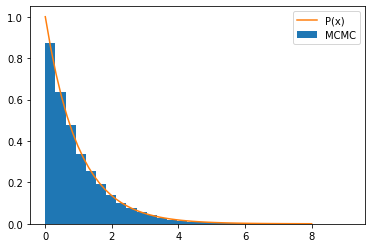

In [92]:
# Check the mean and standard deviation
print("The true mean and standard deviation is", 1/a)
print("Our estimated mean is", np.mean(x_samples))
print("Our estimated standard deviation is", np.std(x_samples))

# Plot a histogram of our sample
plt.hist(x_samples,bins=30,density=True,label='MCMC')

# Compare to our PDF
x = np.linspace(0,8)
plt.plot(x,P(x),label='P(x)')

plt.legend()
plt.show()

## <font color=#46769B>MCMCs gone bad</font>

Let's see what happens if some aspects of our simulation go wrong. First, put the above code in a function so we can perform an MCMC simulation for difference values of $\sigma_q$ and $x_0$.

The best thing you can do is just plot your chains and see what they *look like*. Just do the following: `plt.plot(x_samples)`. This will plot each sample $x_i$ as a function of $i$. Below, we will plot only the first 1000 entries in our chains using array slicing: `x_samples[:1000]`.

In [65]:
def MCMC_simulation(x0,sigma_q):

    num = 10**5
    
    # Initialize the first value in the chain [x0]
    x_samples = [x0]

    for i in range(num-1):

        # Previous value of x
        x_old = x_samples[i]

        # Sample new value of x
        x_new = np.random.normal(x_old,sigma_q)

        # Acceptance ratio
        A = P(x_new)/P(x_old)

        # Check whether accept or reject

        # Accept always
        if A > 1:
            x_samples.append(x_new)

        # Accept with probability A
        else:
            # Randomly decide to accept
            r = np.random.rand()
            if r < A:
                x_samples.append(x_new)
            else:
                x_samples.append(x_old)
                
    return x_samples

### <font color=#46769B>Long burn-in (bad initial point $x_0$)</font>

Let's consider what happens when $x_0$ is (very) far from the most probable region. The further it is, the longer the burn-in period that would need to be discarded from the chain.

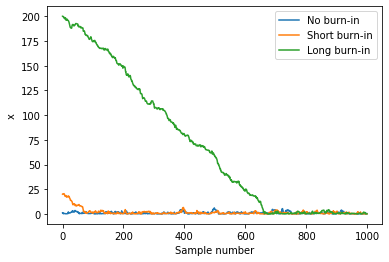

In [93]:
# No burn-in (same as above)
# Plot first 1000 samples
x_samples = MCMC_simulation(1,1)
plt.plot(x_samples[:1000],label='No burn-in')

# Short burn-in 
# Plot first 1000 samples
x_samples = MCMC_simulation(20,1)
plt.plot(x_samples[:1000],label='Short burn-in')

# Long burn-in 
# Plot first 1000 samples
x_samples = MCMC_simulation(200,1)
plt.plot(x_samples[:1000],label='Long burn-in')

plt.xlabel('Sample number')
plt.ylabel('x')
plt.legend()
plt.show()

In [95]:
np.mean(x_samples[1000:])

1.0103781117746757

### <font color=#46769B>Too large or too small step-size (bad $\sigma_q$)</font>

Here we illustrate what goes wrong if $\sigma_q$ is not tuned correctly.
- For the ideal step-size, your samples should just look *like noise*.
- For too large a step-size, your samples will look "blocky." This is because many samples get rejected, so there are many repeated entries in the chain. 
- For too small a step-size, your chain will take large "excursions" through the parameter space. These many small steps will introduce correlations between elements of your chain, and your chain will not reproduce the true distribution.

As above, you can clearly see these features if you *just look at the chains*.

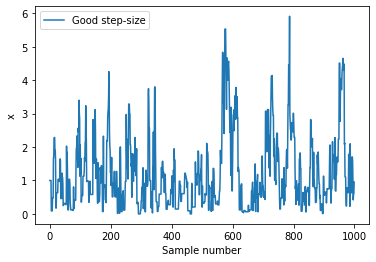

The true mean and standard deviation is 1.0
Our estimated mean is 0.9812442229406352
Our estimated standard deviation is 0.9573226199169793


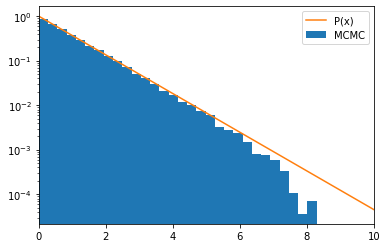

In [96]:
# Medium step-size (same as above)
# Plot first 1000 samples
x_samples = MCMC_simulation(1,1)
plt.plot(x_samples[:1000],label='Good step-size')
plt.xlabel('Sample number')
plt.ylabel('x')
plt.legend()
plt.show()

# Check the mean and standard deviation
print("The true mean and standard deviation is", 1/a)
print("Our estimated mean is", np.mean(x_samples))
print("Our estimated standard deviation is", np.std(x_samples))

# Plot a histogram of our sample
plt.hist(x_samples,bins=30,density=True,label='MCMC')

# Compare to our PDF
x = np.linspace(0,10)
plt.plot(x,P(x),label='P(x)')

plt.xlim([0,10])
plt.yscale('log')
plt.legend()
plt.show()

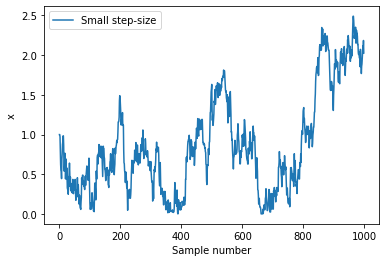

The true mean and standard deviation is 1.0
Our estimated mean is 0.9659922882865665
Our estimated standard deviation is 0.8801000767698813


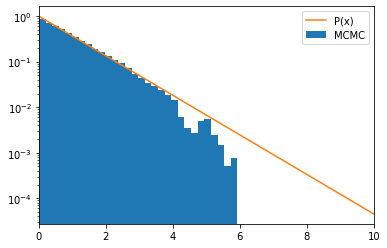

In [97]:
# Small step-size
# Plot first 1000 samples
x_samples = MCMC_simulation(1,0.1)
plt.plot(x_samples[:1000],label='Small step-size')
plt.xlabel('Sample number')
plt.ylabel('x')
plt.legend()
plt.show()

# Check the mean and standard deviation
print("The true mean and standard deviation is", 1/a)
print("Our estimated mean is", np.mean(x_samples))
print("Our estimated standard deviation is", np.std(x_samples))

# Plot a histogram of our sample
plt.hist(x_samples,bins=30,density=True,label='MCMC')

# Compare to our PDF
x = np.linspace(0,10)
plt.plot(x,P(x),label='P(x)')

plt.xlim([0,10])
plt.yscale('log')
plt.legend()
plt.show()

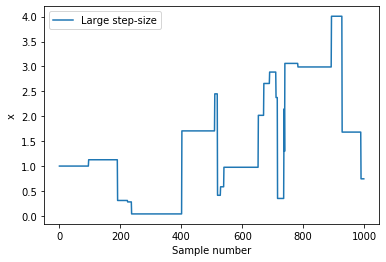

The true mean and standard deviation is 1.0
Our estimated mean is 0.9355421691571582
Our estimated standard deviation is 0.9527403680152982


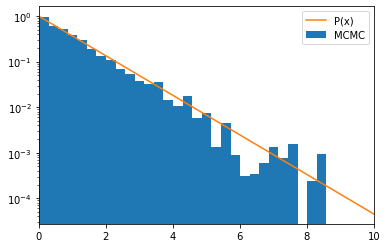

In [98]:
# Large step-size
# Plot first 1000 samples
x_samples = MCMC_simulation(1,50)
plt.plot(x_samples[:1000],label='Large step-size')
plt.xlabel('Sample number')
plt.ylabel('x')
plt.legend()
plt.show()

# Check the mean and standard deviation
print("The true mean and standard deviation is", 1/a)
print("Our estimated mean is", np.mean(x_samples))
print("Our estimated standard deviation is", np.std(x_samples))

# Plot a histogram of our sample
plt.hist(x_samples,bins=30,density=True,label='MCMC')

# Compare to our PDF
x = np.linspace(0,10)
plt.plot(x,P(x),label='P(x)')

plt.xlim([0,10])
plt.yscale('log')
plt.legend()
plt.show()